In [38]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from pathlib import Path
from PIL import Image
from skimage.measure import moments_hu
from mahotas.features import zernike_moments
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

#rutas
DATASET_PATH = Path('dataset/all-images') 
CLASSES = ['circle', 'square', 'triangle']

# semilla para reproducibilidad
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

print(f" ruta del dataset configurada: {DATASET_PATH}")
print(f" clases a clasificar: {CLASSES}")

 ruta del dataset configurada: dataset/all-images
 clases a clasificar: ['circle', 'square', 'triangle']


In [39]:
def preprocess_image(image_path, target_size=(128, 128)):
    """Carga, redimensiona, convierte a escala de grises y normaliza."""
    try:
        img = Image.open(image_path)
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        if img.mode != 'L':
            img = img.convert('L')
        img_array = np.array(img, dtype=np.float32)
        return img_array / 255.0  # Normalización [0, 1]
    except Exception as e:
        print(f"Error en {image_path}: {e}")
        return None

def load_dataset(base_path, classes):
    X, y = [], []
    print(" Cargando imagenes...")
    for idx, class_name in enumerate(classes):
        path = base_path / class_name
        files = list(path.glob('*.[jpJP][npNP][gG]*'))
        print(f"   - {class_name}: {len(files)} imagenes encontradas.")
        
        for file in files:
            img = preprocess_image(file)
            if img is not None:
                X.append(img)
                y.append(idx)
    
    return np.array(X), np.array(y)

# cargar y dividir datos
X, y = load_dataset(DATASET_PATH, CLASSES)

# split 80 Train - 20 Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

print(f"\n dataset cargado: {len(X)} imagenes totales.")
print(f" train: {X_train.shape[0]} | test: {X_test.shape[0]}")

 Cargando imagenes...
   - circle: 114 imagenes encontradas.
   - square: 129 imagenes encontradas.
   - triangle: 115 imagenes encontradas.

 dataset cargado: 358 imagenes totales.
 train: 286 | test: 72


 visualizando muestras del dataset...


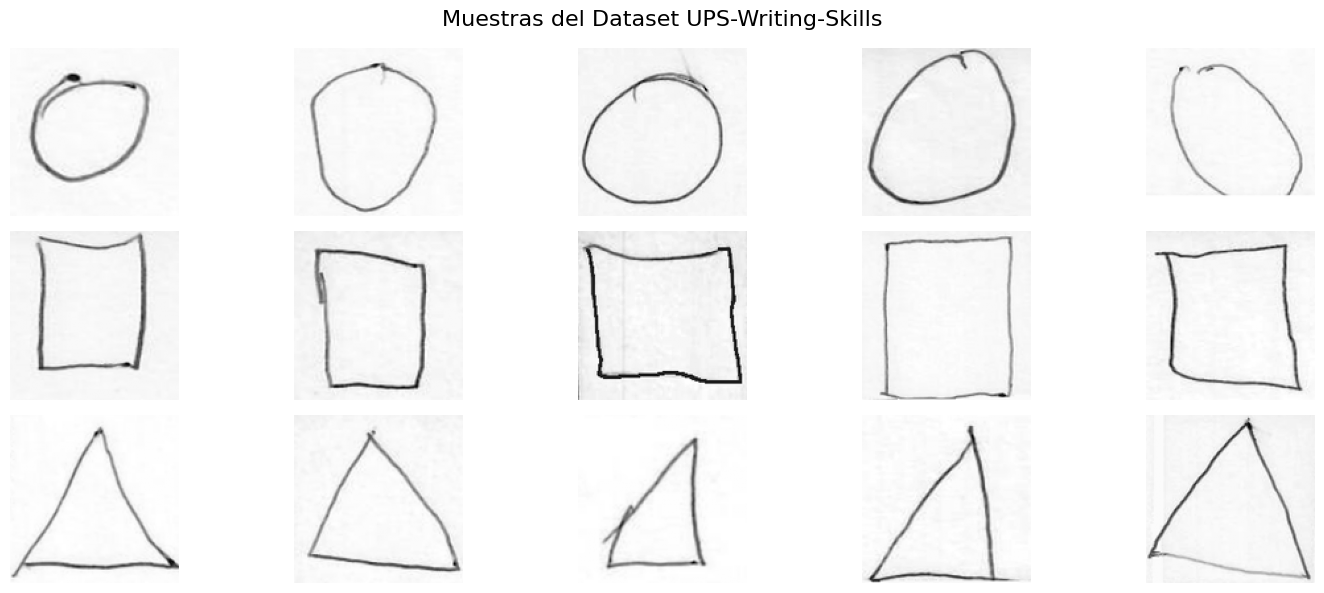

In [40]:
def show_samples(X, y, classes, samples=5):
    """Muestra muestras aleatorias de cada clase."""
    fig, axes = plt.subplots(len(classes), samples, figsize=(15, 6))
    fig.suptitle('Muestras del Dataset UPS-Writing-Skills', fontsize=16)
    
    for i, class_name in enumerate(classes):
        idxs = np.where(y == i)[0]
        # seleccionar muestras aleatorias
        sample_idxs = np.random.choice(idxs, samples, replace=False)
        
        for j, idx in enumerate(sample_idxs):
            ax = axes[i, j]
            ax.imshow(X[idx], cmap='gray')
            if j == 0:
                ax.set_ylabel(class_name.upper(), fontsize=12, fontweight='bold')
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

print(" visualizando muestras del dataset...")
show_samples(X_train, y_train, CLASSES)

In [41]:
def add_gaussian_noise(image, intensity='low'):
    """Añade ruido Gaussiano segun intensidad."""
    levels = {'low': 0.05, 'medium': 0.1, 'high': 0.2}
    sigma = levels.get(intensity, 0.05)
    noise = np.random.normal(0, sigma, image.shape)
    return np.clip(image + noise, 0, 1)

def add_salt_pepper_noise(image, intensity='low'):
    """Añade ruido Sal y Pimienta."""
    levels = {'low': 0.05, 'medium': 0.1, 'high': 0.2} # % de pixeles afectados
    prob = levels.get(intensity, 0.05)
    output = image.copy()
    
    # mascara aleatoria
    rnd = np.random.random(image.shape)
    output[rnd < prob/2] = 0.0     # Pimienta (negro)
    output[rnd > 1 - prob/2] = 1.0 # Sal (blanco)
    return output

def rotate_image(image):
    """Rota la imagen un ángulo aleatorio entre 0 y 360 grados."""
    angle = np.random.uniform(0, 360)
    h, w = image.shape
    center = (w // 2, h // 2)
    # matriz de rotacion (centro, angulo, escala)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), borderValue=0.0)

print(" Funciones de ruido (gaussiano, S&P y rotación) listas.")

 Funciones de ruido (gaussiano, S&P y rotación) listas.


 probando aumentos en imagen clase: triangle


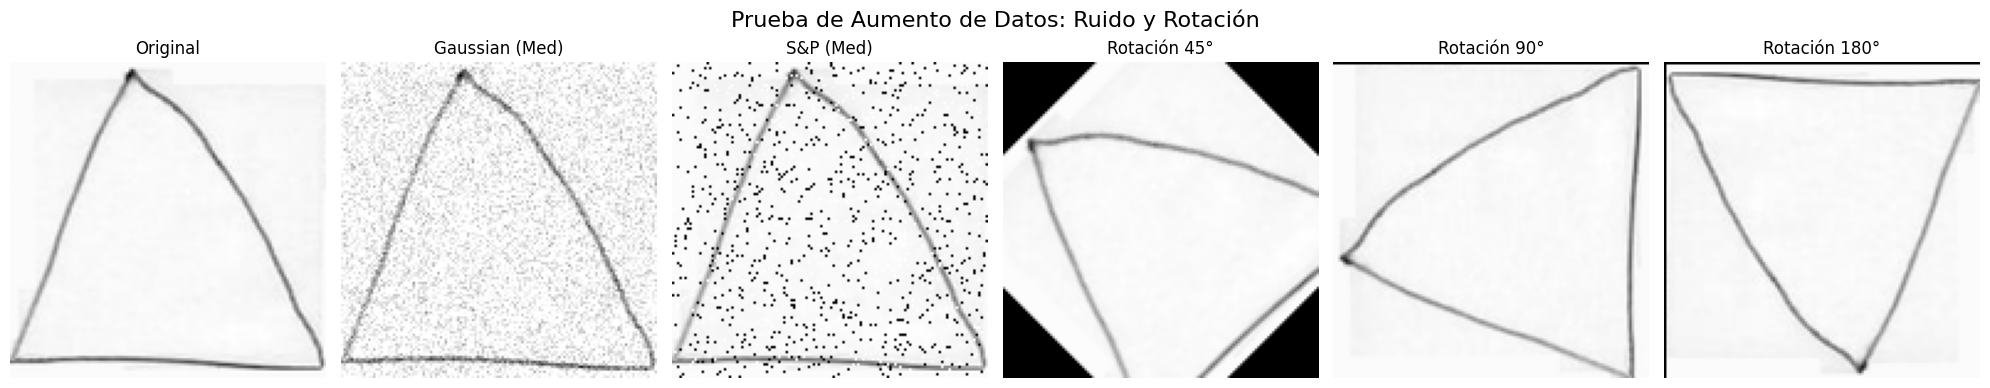

In [42]:
def show_augmentations(image):
    """Muestra original, ruidos y rotación para demostrar robustez."""
    
    # funcion auxiliar para rotar solo para visualizacion
    def rotate_img(img, angle):
        h, w = img.shape
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        return cv2.warpAffine(img, M, (w, h), borderValue=0.0) # fondo negro

    fig, axes = plt.subplots(1, 6, figsize=(20, 4))
    fig.suptitle('Prueba de Aumento de Datos: Ruido y Rotación', fontsize=16)
    
    # 1. original
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("Original")
    
    # 2. ruido Gaussiano
    axes[1].imshow(add_gaussian_noise(image, 'medium'), cmap='gray')
    axes[1].set_title("Gaussian (Med)")
    
    # 3. ruido Sal y Pimienta
    axes[2].imshow(add_salt_pepper_noise(image, 'medium'), cmap='gray')
    axes[2].set_title("S&P (Med)")
    
    # 4. rotaciones (demostrando requisito de invarianza)
    axes[3].imshow(rotate_img(image, 45), cmap='gray')
    axes[3].set_title("Rotación 45°")
    
    axes[4].imshow(rotate_img(image, 90), cmap='gray')
    axes[4].set_title("Rotación 90°")
    
    axes[5].imshow(rotate_img(image, 180), cmap='gray')
    axes[5].set_title("Rotación 180°")
    
    for ax in axes: ax.axis('off')
    plt.tight_layout()
    plt.show()

# tomar una imagen aleatoria del test set para probar
sample_idx = random.randint(0, len(X_test)-1)
print(f" probando aumentos en imagen clase: {CLASSES[y_test[sample_idx]]}")
show_augmentations(X_test[sample_idx])

In [43]:
def extract_hu_moments(img):
    """Calcula 7 momentos de Hu + Log transform."""
    # Convertir a uint8 para skimage (necesita rango 0-255 o similar para momentos raw)
    # Pero moments_hu de skimage trabaja bien sobre float, sin embargo la guia pide Log transform
    m = moments_hu(img)
    # Transformación Log para manejar escalas (copiando lógica de clase)
    return -1 * np.sign(m) * np.log10(np.abs(m) + 1e-10)

def extract_zernike_moments(img, radius=64, degree=8):
    """Calcula momentos de Zernike (grado 8)."""
    # Zernike requiere imagen binaria o uint8 y un radio
    img_uint8 = (img * 255).astype(np.uint8)
    return zernike_moments(img_uint8, radius, degree)

def get_features(images, method='hu'):
    features = []
    for img in images:
        if method == 'hu':
            features.append(extract_hu_moments(img))
        elif method == 'zernike':
            features.append(extract_zernike_moments(img))
    return np.array(features)

print(" extractores Hu (Log) y Zernike (n=8) listos.")

 extractores Hu (Log) y Zernike (n=8) listos.


 generando matrices de confusión...


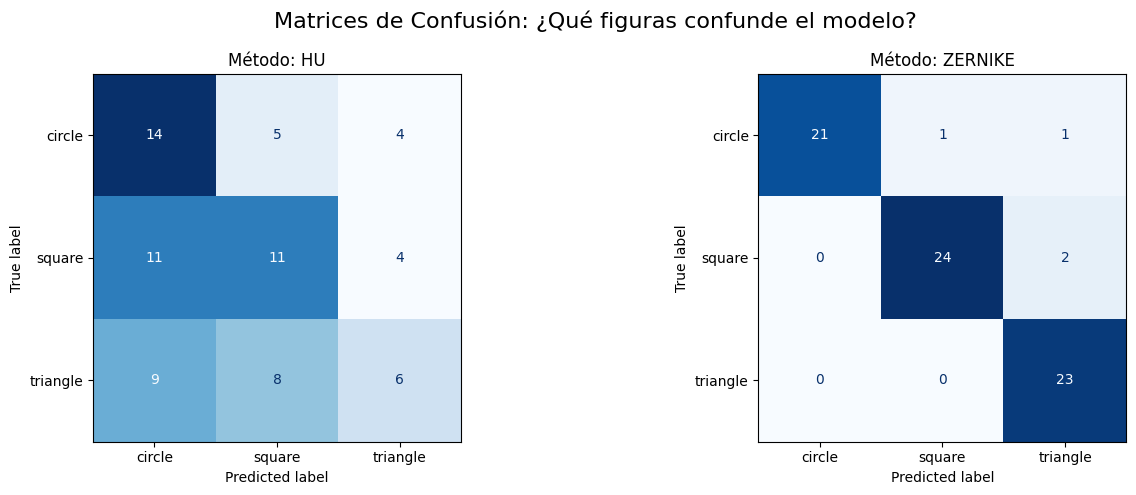

In [44]:
def plot_confusion_matrices(models, X_test, y_test, classes):
    """Muestra matrices de confusión para los mejores modelos."""
    # Seleccionamos solo un par de modelos representativos para no llenar la pantalla
    methods_to_show = ['hu_KNN', 'zernike_SVM']
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    fig.suptitle('Matrices de Confusión: ¿Qué figuras confunde el modelo?', fontsize=16)
    
    for i, key in enumerate(methods_to_show):
        if key in models:
            model, scaler = models[key]
            # Extraer características según el nombre del método (hu o zernike)
            method_name = key.split('_')[0] 
            
            # Preparar datos
            feats = get_features(X_test, method=method_name)
            feats_scaled = scaler.transform(feats)
            
            # Predecir y graficar
            y_pred = model.predict(feats_scaled)
            cm_display = ConfusionMatrixDisplay.from_predictions(
                y_test, y_pred, display_labels=classes, 
                cmap='Blues', ax=axes[i], colorbar=False
            )
            axes[i].set_title(f"Método: {method_name.upper()}", fontsize=12)
            
    plt.tight_layout()
    plt.show()

print(" generando matrices de confusión...")
# Usamos los modelos ya entrenados en la celda anterior
if 'models' in globals():
    plot_confusion_matrices(models, X_test, y_test, CLASSES)

In [45]:
from sklearn.base import clone

# Definir plantillas
classifier_templates = {
    'SVM': SVC(kernel='rbf', random_state=SEED),
    'KNN': KNeighborsClassifier(n_neighbors=5)
}

methods = ['hu', 'zernike']

print(" iniciando evaluación de robustez (con rotación)...")
print(f"{'MÉTODO':<10} | {'CLF':<5} | {'CONDICIÓN':<15} | {'ACCURACY':<8}")
print("-" * 55)

models = {}

# 1. entrenamiento (siempre con datos limpios y sin rotar)
for m in methods:
    X_train_feat = get_features(X_train, method=m)
    scaler = StandardScaler().fit(X_train_feat)
    X_train_scaled = scaler.transform(X_train_feat)
    
    for clf_name, clf_template in classifier_templates.items():
        clf = clone(clf_template)
        clf.fit(X_train_scaled, y_train)
        models[f"{m}_{clf_name}"] = (clf, scaler)

# 2. evaluación (agregamos Rotation a la lista)
noise_configs = [
    ('Original', 'None'), 
    ('Gaussian', 'medium'), 
    ('S&P', 'medium'),
    ('Rotation', 'Random')  
]

for m in methods:
    for clf_name in classifier_templates.keys():
        model, scaler = models[f"{m}_{clf_name}"]
        
        for condition, level in noise_configs:
            # Preparar Test Set según condición
            if condition == 'Original':
                X_test_aug = X_test
            elif condition == 'Rotation':
                X_test_aug = np.array([rotate_image(img) for img in X_test])
            else:
                X_test_aug = []
                for img in X_test:
                    if condition == 'Gaussian':
                        X_test_aug.append(add_gaussian_noise(img, level))
                    else:
                        X_test_aug.append(add_salt_pepper_noise(img, level))
                X_test_aug = np.array(X_test_aug)
            
            # Predecir
            feats = get_features(X_test_aug, method=m)
            feats_scaled = scaler.transform(feats)
            acc = accuracy_score(y_test, model.predict(feats_scaled))
            
            print(f"{m:<10} | {clf_name:<5} | {condition:<15} | {acc:.4f}")

 iniciando evaluación de robustez (con rotación)...
MÉTODO     | CLF   | CONDICIÓN       | ACCURACY
-------------------------------------------------------
hu         | SVM   | Original        | 0.3889
hu         | SVM   | Gaussian        | 0.3194
hu         | SVM   | S&P             | 0.3472
hu         | SVM   | Rotation        | 0.3611
hu         | KNN   | Original        | 0.4306
hu         | KNN   | Gaussian        | 0.2778
hu         | KNN   | S&P             | 0.3889
hu         | KNN   | Rotation        | 0.3611
zernike    | SVM   | Original        | 0.9444
zernike    | SVM   | Gaussian        | 0.9306
zernike    | SVM   | S&P             | 0.9167
zernike    | SVM   | Rotation        | 0.8889
zernike    | KNN   | Original        | 0.9028
zernike    | KNN   | Gaussian        | 0.9167
zernike    | KNN   | S&P             | 0.8750
zernike    | KNN   | Rotation        | 0.8750


In [46]:
def get_shape_signature_features(image, num_points=64, descriptors=16):
    """
    Implementa la lógica de Shape Signature con coordenadas complejas y FFT.
    Simula lo que hará la App Móvil en C++.
    """
    # 1. binarizacion y contornos
    # convertir a uint8 (0-255)
    img_uint8 = (image * 255).astype(np.uint8)
    
    # binarizacion adaptativa para ser robusto a iluminacion
    bin_img = cv2.adaptiveThreshold(img_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    
    # encontrar contornos externos
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    # si no hay contorno, retornar ceros
    if not contours: 
        return np.zeros(descriptors)
    
    # tomar el contorno más grande
    cnt = max(contours, key=cv2.contourArea)
    
    # filtrar ruido muy pequeño
    if len(cnt) < 5: 
        return np.zeros(descriptors) 
    
    # 2. resamplear a N puntos fijos (interpolacion)
    # esto es crucial para que todas las FFT tengan el mismo tamaño
    cnt = cnt.reshape(-1, 2)
    x, y = cnt[:, 0], cnt[:, 1]
    
    # interpolacion lineal para obtener exactamente 'num_points'
    t = np.linspace(0, 1, len(cnt))
    t_new = np.linspace(0, 1, num_points)
    x_new = np.interp(t_new, t, x)
    y_new = np.interp(t_new, t, y)
    
    # 3. coordenadas Complejas Centradas: s(n) = (x - xc) + j(y - yc)
    centroid_x, centroid_y = np.mean(x_new), np.mean(y_new)
    complex_signal = (x_new - centroid_x) + 1j * (y_new - centroid_y)
    
    # 4. FFT y Normalización
    fft = np.fft.fft(complex_signal)
    
    # invarianza a escala: Dividir por magnitud del primer armónico |F(1)|
    if np.abs(fft[1]) > 1e-10:
        fft = fft / np.abs(fft[1])
        
    # invarianza a rotación: tomar solo la magnitud |F(k)| (descartar fase)
    descriptors_fft = np.abs(fft)
    
    # retornar los primeros K descriptores (saltando DC=0 porque es 0 al centrar)
    # se toman desde el indice 1 hasta descriptors+1
    if len(descriptors_fft) > descriptors + 1:
        return descriptors_fft[1:descriptors+1]
    else:
        # rellenar con ceros si la señal es muy corta
        return np.pad(descriptors_fft[1:], (0, descriptors - len(descriptors_fft) + 1))

print(" logica Shape Signature (FFT Compleja) implementada.")

 logica Shape Signature (FFT Compleja) implementada.


 visualizando el proceso interno de Shape Signature...


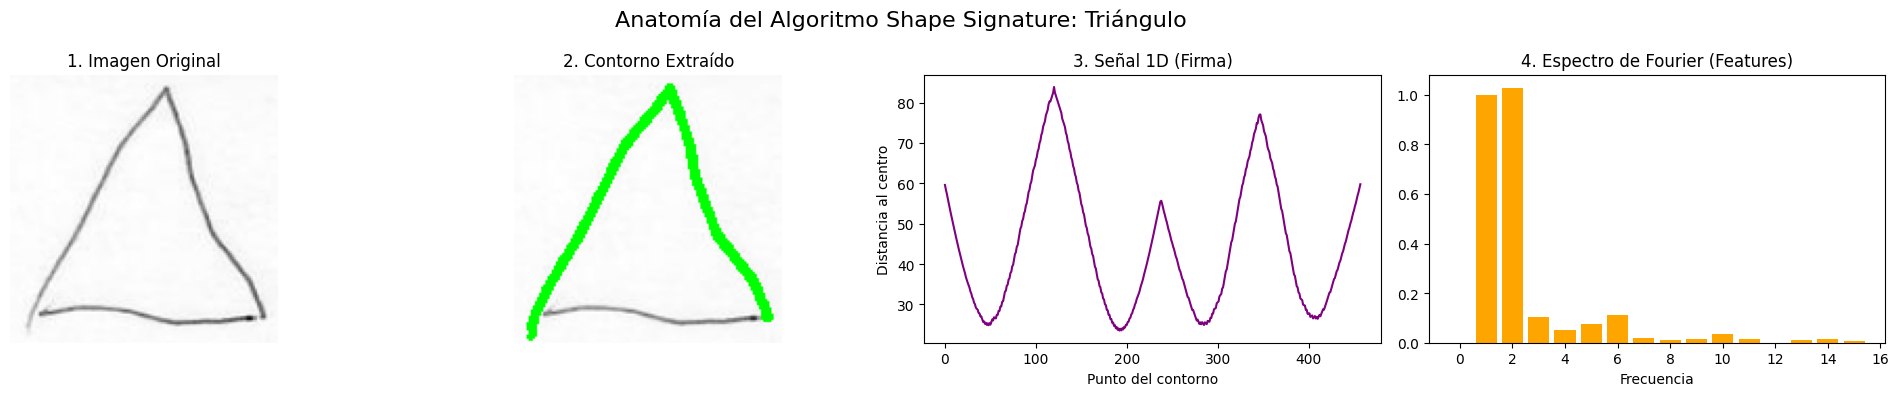

In [47]:
def visualize_shape_signature_process(image, title="Ejemplo de Proceso"):
    """Desglosa visualmente cómo funciona el algoritmo de Shape Signature."""
    
    # 1. obtener contorno (lógica interna replicada para visualización)
    img_uint8 = (image * 255).astype(np.uint8)
    bin_img = cv2.adaptiveThreshold(img_uint8, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                    cv2.THRESH_BINARY_INV, 11, 2)
    contours, _ = cv2.findContours(bin_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours: return
    cnt = max(contours, key=cv2.contourArea)
    
    # interpolación para señal 1D
    cnt = cnt.reshape(-1, 2)
    # centrar
    centroid = np.mean(cnt, axis=0)
    centered = cnt - centroid
    
    # calcular distancias al centroide (Firma simple para visualización)
    # nota: La FFT usa coordenadas complejas, aquí graficamos magnitud para entenderlo visualmente
    distances = np.sqrt(centered[:, 0]**2 + centered[:, 1]**2)
    
    # calcular FFT (lo que realmente usa el clasificador)
    complex_signal = centered[:, 0] + 1j * centered[:, 1]
    fft = np.fft.fft(complex_signal)
    fft_magnitude = np.abs(fft)[:16] # primeros 16 descriptores
    fft_magnitude = fft_magnitude / (fft_magnitude[1] + 1e-10) # normalizado

    # --- GRAFICAR ---
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    fig.suptitle(f'Anatomía del Algoritmo Shape Signature: {title}', fontsize=16)
    
    # Paso 1: imagen original
    axes[0].imshow(image, cmap='gray')
    axes[0].set_title("1. Imagen Original")
    
    # Paso 2: contorno extraido
    debug_img = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(debug_img, [cnt.reshape(-1, 1, 2)], -1, (0, 255, 0), 2)
    axes[1].imshow(debug_img)
    axes[1].set_title("2. Contorno Extraído")
    
    # Paso 3: la "firma" (distancia vs angulo)
    axes[2].plot(distances, color='purple')
    axes[2].set_title("3. Señal 1D (Firma)")
    axes[2].set_xlabel("Punto del contorno")
    axes[2].set_ylabel("Distancia al centro")
    
    # Paso 4: descriptores de Fourier (FFT)
    axes[3].bar(range(len(fft_magnitude)), fft_magnitude, color='orange')
    axes[3].set_title("4. Espectro de Fourier (Features)")
    axes[3].set_xlabel("Frecuencia")
    
    for ax in axes: 
        if ax != axes[2] and ax != axes[3]: ax.axis('off')
    plt.tight_layout()
    plt.show()

# visualizar con una imagen de prueba
# buscamos un indice que sea un triangulo (clase 2)
idx_tri = np.where(y_train == 2)[0][0]
print(" visualizando el proceso interno de Shape Signature...")
visualize_shape_signature_process(X_train[idx_tri], title="Triángulo")

In [51]:
# evaluación Shape Signature 
print(" evaluando shape signature...")
print(f"{'MÉTODO':<18} | {'CONDICIÓN':<15} | {'ACCURACY':<8}")
print("-" * 55)

# asegurar que tenemos la lista de condiciones completa
noise_configs = [
    ('Original', 'None'), 
    ('Gaussian', 'medium'), 
    ('S&P', 'medium'),
    ('Rotation', 'Random')  # <--- Esto es lo importante
]

# entrenar (si no está entrenado ya)
X_train_ss = np.array([get_shape_signature_features(img) for img in X_train])
scaler_ss = StandardScaler().fit(X_train_ss)
X_train_ss_scaled = scaler_ss.transform(X_train_ss)
knn_ss = KNeighborsClassifier(n_neighbors=3)
knn_ss.fit(X_train_ss_scaled, y_train)

# evaluar
for condition, level in noise_configs:
    if condition == 'Original':
        X_test_aug = X_test
    elif condition == 'Rotation':
        X_test_aug = np.array([rotate_image(img) for img in X_test])
    else:
        X_test_aug = []
        for img in X_test:
            if condition == 'Gaussian':
                X_test_aug.append(add_gaussian_noise(img, level))
            else:
                X_test_aug.append(add_salt_pepper_noise(img, level))
        X_test_aug = np.array(X_test_aug)

    feats_test = np.array([get_shape_signature_features(img) for img in X_test_aug])
    feats_test_scaled = scaler_ss.transform(feats_test)
    acc = knn_ss.score(feats_test_scaled, y_test)
    print(f"{'ShapeSig (FFT)':<18} | {condition:<15} | {acc:.4f}")

 evaluando shape signature...
MÉTODO             | CONDICIÓN       | ACCURACY
-------------------------------------------------------
ShapeSig (FFT)     | Original        | 0.8194
ShapeSig (FFT)     | Gaussian        | 0.4028
ShapeSig (FFT)     | S&P             | 0.6250
ShapeSig (FFT)     | Rotation        | 0.5972


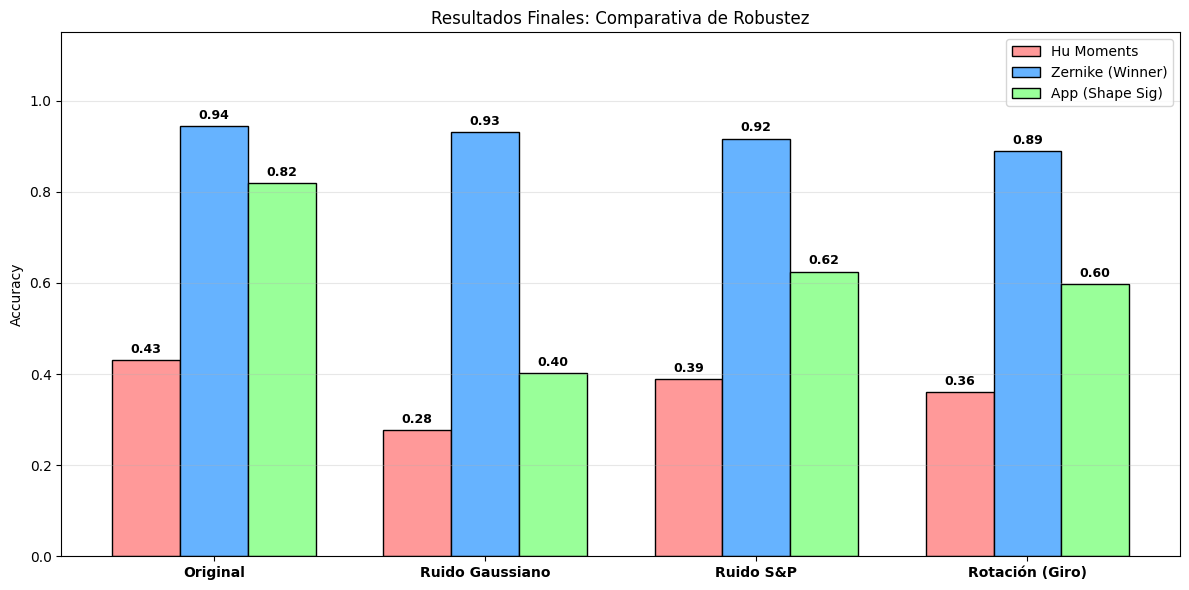

In [52]:
import matplotlib.pyplot as plt
import numpy as np

def plot_final_results():
    labels = ['Original', 'Ruido Gaussiano', 'Ruido S&P', 'Rotación (Giro)']
    x = np.arange(len(labels))
    width = 0.25
    
    hu_scores = [0.4306, 0.2778, 0.3889, 0.3611]
    
    zernike_scores = [0.9444, 0.9306, 0.9167, 0.8889]
    
    ss_scores = [0.8194, 0.4028, 0.6250, 0.5972] 
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    rects1 = ax.bar(x - width, hu_scores, width, label='Hu Moments', color='#ff9999', edgecolor='black')
    rects2 = ax.bar(x, zernike_scores, width, label='Zernike (Winner)', color='#66b3ff', edgecolor='black')
    rects3 = ax.bar(x + width, ss_scores, width, label='App (Shape Sig)', color='#99ff99', edgecolor='black')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Resultados Finales: Comparativa de Robustez')
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1.15)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points",
                        ha='center', va='bottom', fontweight='bold', fontsize=9)

    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    plt.tight_layout()
    plt.show()

plot_final_results()